# **Nilesh Hegde**
## **FAKE NEWS DETECTION**

This notebooks contains code related to Logistic regression, SVM, Random forest, Decision tree and Multinomial naive bayes classifier.

# **NOTE - Please upload the dataset 'data.csv' before executing the notebook**

# **IMPORT LIBRARIES**

Import libraries and modules needed for various functions and uses in this notebook. If needed please install *pandas, matplolib, scikit-learn, wordcloud, nltk* if not modules don't exist

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords,wordnet as wn
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn import model_selection,metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

# **Installing NLTK data**

Please install the following NLTK data that is used in data preprocessing

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Reading data and performing Exploratory Data Analysis (EDA)**

The following cell blocks encompass the process of performing exploratory data analysis and providing an insight on the data.

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data.sample(10)

,id,title,author,text,label
13641,13641,Tragedy: Former NFL Star Todd Heap Accidentall...,Dylan Gwinn,Former NFL tight end Todd Heap accidentally ki...,0
177,177,This Open Letter To Trump Voters Just Told It ...,Colin Taylor,Comments \nAs election day draws closer and cl...,1
18586,18586,Lin-Manuel Miranda announces new musical about...,NaN,Monday 21 November 2016 Lin-Manuel Miranda ann...,1
11174,11174,5 Key Takeaways From President Trump’s Speech ...,Glenn Thrush,"WASHINGTON — In President Trump’s world, bo...",0
15878,15878,FLASHBACK: American Flags Collapse at the Sigh...,The Conservative Millennial,0 comments \nAccording to The Political Inside...,1
2947,2947,Conviction Against Brendan Dassey of ‘Making a...,Daniel Victor,A federal judge on Friday overturned the murde...,0
15647,15647,Facebook Faces High Profile Lawsuit Regarding ...,Michael Krieger,at 3:02 pm Leave a comment \nAs the technology...,1
14289,14289,Trump Allies Dismayed by Huge Number of White ...,John Hayward,The Hill remarks on the high volume of leaks f...,0
9343,9343,'Sacrificing a Chicken to Moloch' — The Clinto...,noreply@blogger.com (Alexander Light),'Sacrificing a Chicken to Moloch'— The Clinton...,1
13846,13846,In-AUGH!-uration: Read the Angriest Lefty Inau...,Jack Hadfield,As Donald Trump was inaugurated as the 45th Pr...,0


In [ ]:
data.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
print('Shape : {}'.format(data.shape))

Shape : (20800, 5)


Text(0.5, 1.0, 'Types of news : 0 - False, 1 - True')

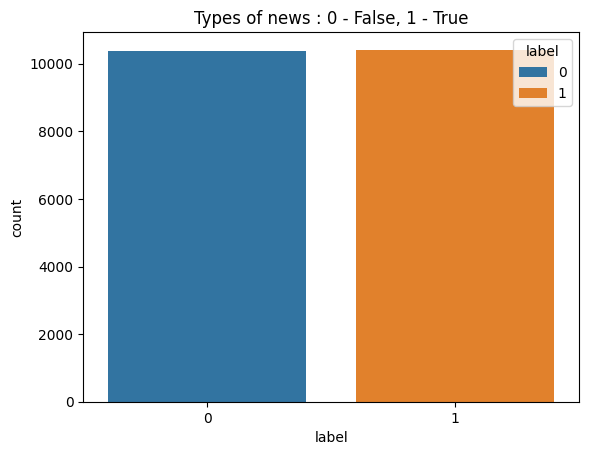

In [ ]:
ax = sns.countplot(x='label', hue='label', dodge=False, data=data)
ax.set_title('Types of news : 0 - False, 1 - True')

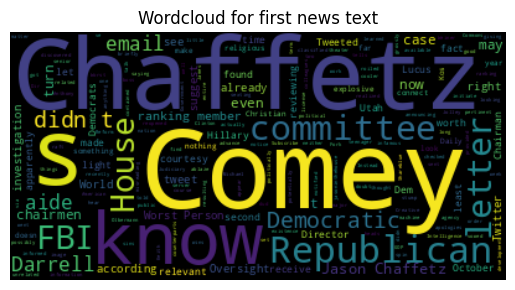

In [ ]:
wordcloud = WordCloud().generate(text = data.text[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud for first news text')
plt.show()

# **Data Preprocessing**

Multiple steps of data preprocessing have been used here. They are -


1.   Remove blank rows if any
2.   Concat title and text columns
2.   Change text to lower case
3.   Tokenization, that is breaking a sentence into words
4.   Removing stop words
5.   Lemmatization



In [ ]:
data['text'].dropna(inplace=True)
data['text'] = data['title'] + ' ' + data['text']
data['text'] = [str(entry).lower() for entry in data['text']]
data['text']= [word_tokenize(str(entry)) for entry in data['text']]
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(data['text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in nltk.pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    data.loc[index,'text_final'] = str(Final_words)

# **Splitting the Data**

Split the data into train set and test set. To evaluate without any shuffling, we will keep first 15000 rows of data for training and remaining data in the beginning for testing.

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(data['text_final'],data['label'],train_size=15000, shuffle=False)

#**TF-IDF Vectorizer**

Apply Term Frequency Inverse Document Frequency to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

#**Machine Learning Models**

### **Logistic Regression Classifier**

Fitting Logistic regression to the training set and evaluating its accuracy on test set. The penaly chosen is  $l_2$,  therefore, the solver used in *liblinear*. Inverse of regularization strength is *5*.


Confusion Matrix


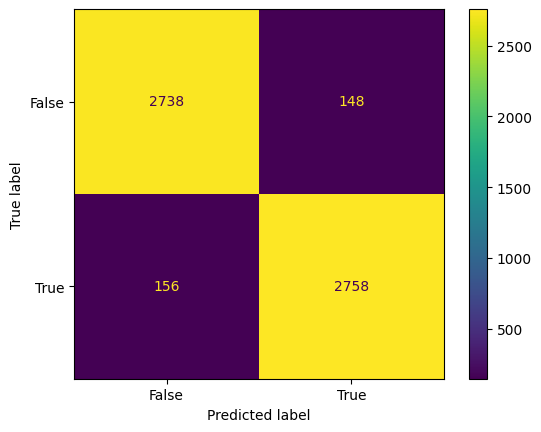


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2886
           1       0.95      0.95      0.95      2914

    accuracy                           0.95      5800
   macro avg       0.95      0.95      0.95      5800
weighted avg       0.95      0.95      0.95      5800

Logistic Regression Classification Accuracy of the model: 94.7586%


In [ ]:
initial_time = time.time()
model = LogisticRegression(solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model.fit(Train_X_Tfidf, Train_Y)
Pred_Y = model.predict(Test_X_Tfidf)
print("Confusion Matrix")
matrix = confusion_matrix(Test_Y, Pred_Y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print("\nClassification Report")
report = classification_report(Test_Y, Pred_Y)
print(report)
accuracy_lr = accuracy_score(Test_Y, Pred_Y)
print('Logistic Regression Classification Accuracy of the model: {:.4f}%'.format(accuracy_lr*100))
total_time_lr = round(time.time()-initial_time,4)

### **Support Vector Machines**

Fitting Support Vector Machine to the training set and evaluating its accuracy on test set. The kernel used in *linear*. Inverse of regularization strength is *1*.


Confusion Matrix


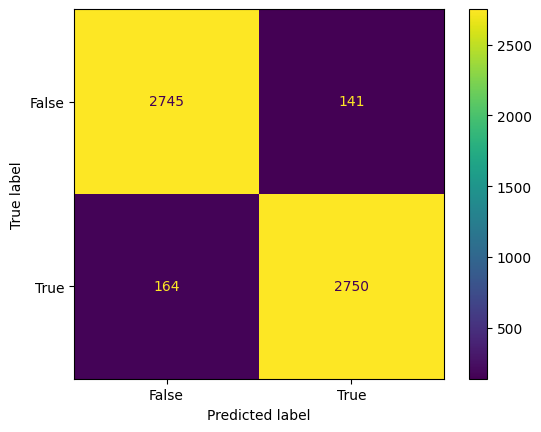


Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2886
           1       0.95      0.94      0.95      2914

    accuracy                           0.95      5800
   macro avg       0.95      0.95      0.95      5800
weighted avg       0.95      0.95      0.95      5800

SVM(Linear kernel) Accuracy of the model: 94.7414%


In [ ]:
initial_time = time.time()
model = SVC(C=1.0, kernel='linear', gamma='auto')
model.fit(Train_X_Tfidf, Train_Y)
Pred_Y = model.predict(Test_X_Tfidf)
print("Confusion Matrix")
matrix = confusion_matrix(Test_Y, Pred_Y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print("\nClassification Report")
report = classification_report(Test_Y, Pred_Y)
print(report)
accuracy_svm = accuracy_score(Test_Y, Pred_Y)
print('SVM(Linear kernel) Accuracy of the model: {:.4f}%'.format(accuracy_svm*100))
total_time_svm = round(time.time()-initial_time,4)

### **Random Forest Classifier**

Fitting Random Forest classifier to the training set and evaluating its accuracy on test set. The number of trees set is *10*. The function to measure the quality of a split is *Entropy*.

Confusion Matrix


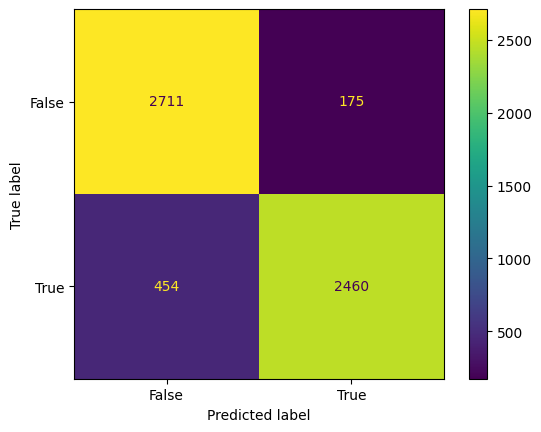


Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2886
           1       0.93      0.84      0.89      2914

    accuracy                           0.89      5800
   macro avg       0.90      0.89      0.89      5800
weighted avg       0.90      0.89      0.89      5800

Random Forest Classification Accuracy of the model: 89.1552%


In [ ]:
initial_time = time.time()
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
model.fit(Train_X_Tfidf, Train_Y)
Pred_Y = model.predict(Test_X_Tfidf)
print("Confusion Matrix")
matrix = confusion_matrix(Test_Y, Pred_Y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print("\nClassification Report")
report = classification_report(Test_Y, Pred_Y)
print(report)
accuracy_rf = accuracy_score(Test_Y, Pred_Y)
print('Random Forest Classification Accuracy of the model: {:.4f}%'.format(accuracy_rf*100))
total_time_rf = round(time.time()-initial_time,4)

### **Multinomial Naive Bayes Classifier**

Fitting Multinomial Naive Bayes classifier to the training set and evaluating its accuracy on test set. The hyperparameters used are *default*.

Confusion Matrix


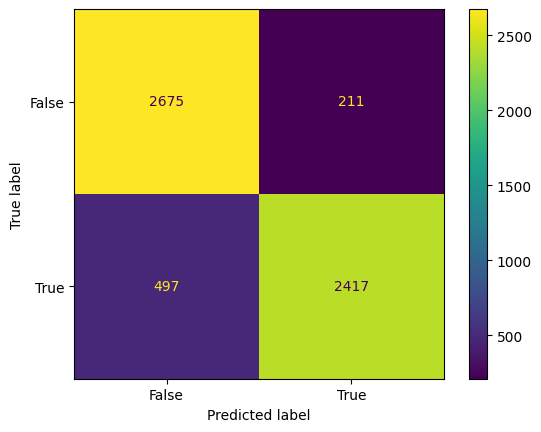


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2886
           1       0.92      0.83      0.87      2914

    accuracy                           0.88      5800
   macro avg       0.88      0.88      0.88      5800
weighted avg       0.88      0.88      0.88      5800

Gaussian NB Classification Accuracy of the model: 87.7931%


In [ ]:
initial_time = time.time()
model = MultinomialNB()
model.fit(Train_X_Tfidf, Train_Y)
Pred_Y = model.predict(Test_X_Tfidf)
print("Confusion Matrix")
matrix = confusion_matrix(Test_Y, Pred_Y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print("\nClassification Report")
report = classification_report(Test_Y, Pred_Y)
print(report)
accuracy_mnb = accuracy_score(Test_Y, Pred_Y)
print('Gaussian NB Classification Accuracy of the model: {:.4f}%'.format(accuracy_mnb*100))
total_time_mnb = round(time.time()-initial_time,4)

### **Decision Tree Classifier**

Fitting Decision Tree to the training set and evaluating its accuracy on test set. The function to measure the quality of a split is *Entropy*.

Confusion Matrix


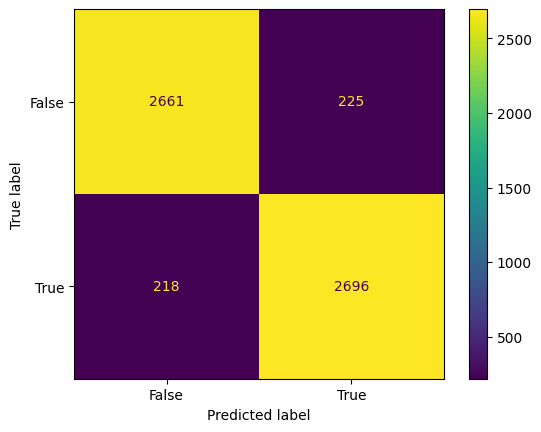


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2886
           1       0.92      0.93      0.92      2914

    accuracy                           0.92      5800
   macro avg       0.92      0.92      0.92      5800
weighted avg       0.92      0.92      0.92      5800

Decision Tree Classification Accuracy of the model: 92.3621%


In [ ]:
initial_time = time.time()
model = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
model.fit(Train_X_Tfidf, Train_Y)
Pred_Y = model.predict(Test_X_Tfidf)
print("Confusion Matrix")
matrix = confusion_matrix(Test_Y, Pred_Y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print("\nClassification Report")
report = classification_report(Test_Y, Pred_Y)
print(report)
accuracy_dc = accuracy_score(Test_Y, Pred_Y)
print('Decision Tree Classification Accuracy of the model: {:.4f}%'.format(accuracy_dc*100))
total_time_dc = round(time.time()-initial_time,4)

# **Comparison Plots**

Here are some comparison plots with regards to accuracies and time taken to train the model.

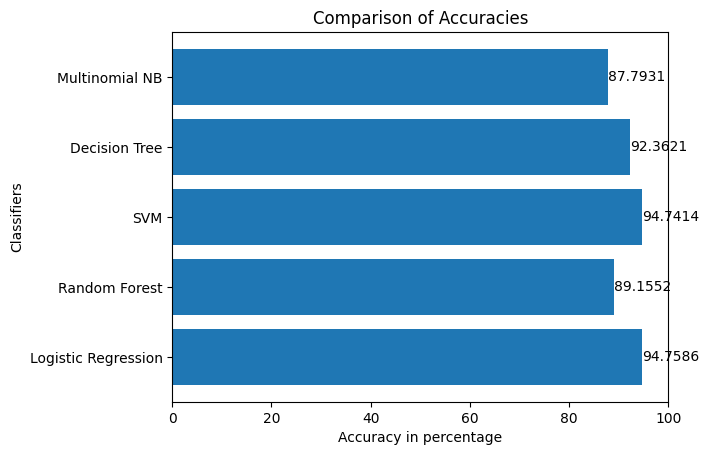

In [ ]:
data = {'Logistic Regression':accuracy_lr*100, 'Random Forest':accuracy_rf*100, 'SVM':accuracy_svm*100,
        'Decision Tree':accuracy_dc*100, 'Multinomial NB':accuracy_mnb*100}
classifiers = list(data.keys())
accuracies = list(data.values())
fig, ax = plt.subplots()
bars = ax.barh(classifiers, accuracies)
ax.bar_label(bars)
plt.xlim(0,100)
plt.xlabel('Accuracy in percentage')
plt.ylabel('Classifiers')
plt.title('Comparison of Accuracies')
plt.show()

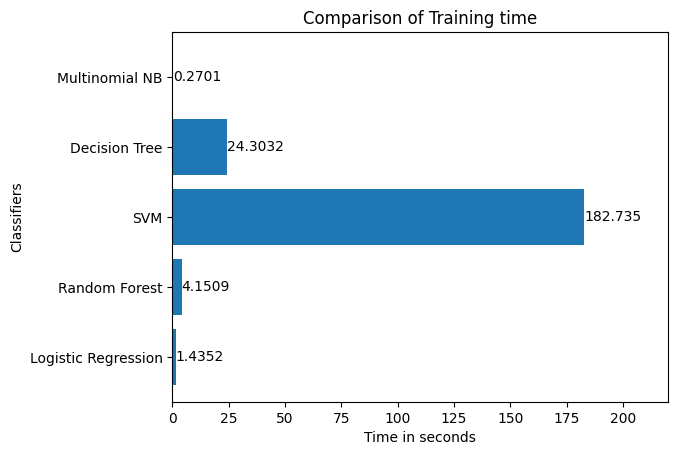

In [ ]:
data = {'Logistic Regression':total_time_lr, 'Random Forest':total_time_rf, 'SVM':total_time_svm,
        'Decision Tree':total_time_dc, 'Multinomial NB':total_time_mnb}
classifiers = list(data.keys())
times = list(data.values())
fig, ax = plt.subplots()
bars = ax.barh(classifiers, times)
ax.bar_label(bars)
plt.xlim(0,220)
plt.xlabel('Time in seconds')
plt.ylabel('Classifiers')
plt.title('Comparison of Training time')
plt.show()